In [5]:
import pickle
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

from _Run_SG import lazy_Run


use _Run_SG.lazy_Run instead of _Run_SG.Run  


In [21]:
# install sklearn
# !pip install scikit-learn 

In [6]:

def load_latents(path):
    # takes names in path 
    names = os.listdir(path)
    names.sort()
    # print(len(names))
    latents = []
    for pkl_name in names:
        with open(path + "/" + pkl_name, 'rb') as f:
            data = pickle.load(f)
            latents.append(data)
    return latents

# visualizations

In [55]:
changes = []
for i in range(len(latents)-1):
    changes.append(latents[i] - latents[0])
    

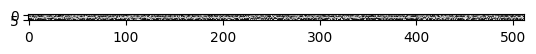

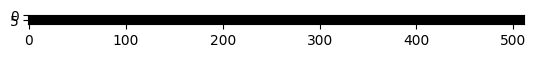

In [56]:
# changes[100]
# plot this as image 
import matplotlib.pyplot as plt
import numpy as np

# plt.imshow(changes[100][0], cmap='gray')
#make large image
# plt.figure(figsize=(20,80))


plt.imshow(changes[100][0][:6], cmap='gray') # first 6 are changed
plt.show()
plt.imshow(changes[100][0][6:], cmap='gray') # unchanged
plt.show()

In [57]:
sum = 0
for i in range(len(changes)):
    sum+=changes[i][0][6:].sum()
print(sum)

0.0


In [58]:
cropped_changes = []
for i in range(len(changes)):
    cropped_changes.append(changes[i][0][:6].flatten()) #(6,512)


In [1]:
def pca(data):
    cropped_changes = np.array(data)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(cropped_changes)
    return components

In [2]:
    # visualize using TSNE
def visualize_tsne(cropped_changes):
        data = np.array(cropped_changes)
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(data)

        plt.scatter(tsne_results[:,0], tsne_results[:,1])
        plt.show()
        return tsne_results

In [3]:
def create_animation(results,anim_name="animation.gif"):
    # create animation of moving point
    import matplotlib.animation as animation
    from matplotlib.animation import FuncAnimation


    fig, ax = plt.subplots()
    xdata, ydata = [], []
    ln, = plt.plot([], [], 'ro')

    def init():
        # ax.set_xlim(-100, 100)
        # ax.set_ylim(-100, 100)
        # pick limits based on data
        # max_x = max(results[:,0])
        # min_x = min(results[:,0])
        # max_y = max(results[:,1])
        # min_y = min(results[:,1])
        max_x,min_x,max_y,min_y = max(results[:,0]),min(results[:,0]),max(results[:,1]),min(results[:,1])
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        
        return ln,

    def update(frame):
        xdata.append(frame[0])
        ydata.append(frame[1])
        ln.set_data(xdata, ydata)
        return ln,

    ani = FuncAnimation(fig, update, frames=results, init_func=init, blit=True) # frames=results
    # plt.show()

    # ani.save('animation.gif', writer='imagemagick', fps=30)
    ani.save(anim_name, writer='imagemagick', fps=30)



In [24]:
# original latents visualization

#load latents 
_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy_latent_edit/latents/barcelona/PTI"
_dirs = os.listdir(_path)
latents_paths = [os.path.join(_path, _dir,"0.pt") for _dir in _dirs]
latents = [torch.load(path).detach().cpu().flatten() for path in latents_paths]


results = visualize_tsne(latents)
create_animation(results,anim_name="tsne_results_original.gif")


MovieWriter imagemagick unavailable; using Pillow instead.


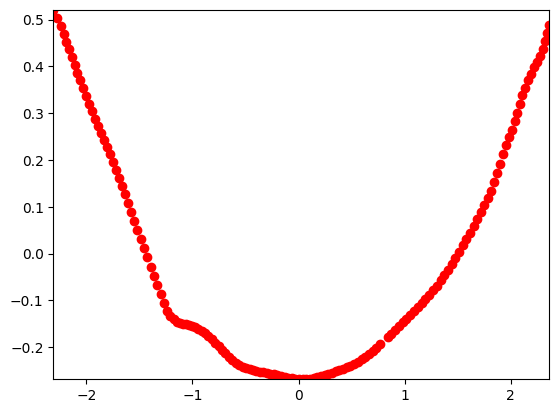

In [63]:
# results = visualize_tsne(cropped_changes)
data = pca(cropped_changes)
create_animation(data,anim_name="pca.gif")


In [68]:
l1 = latents[0][0][:6] #(6, 512)
l_50 = latents[50][0][:6]
l_100 = latents[100][0][:6]

In [71]:
512/8,6*8

(64.0, 48)

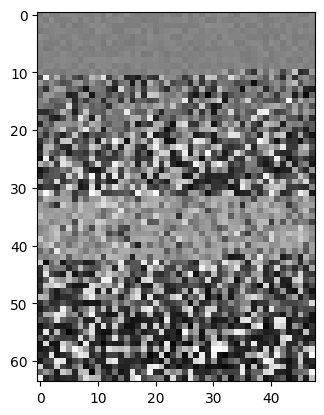

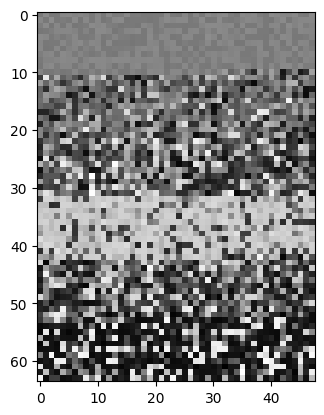

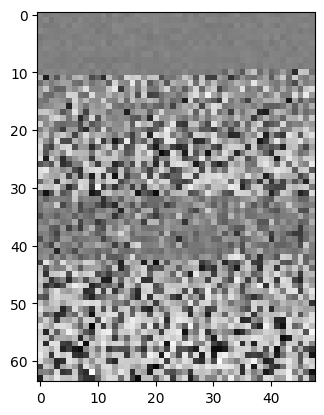

In [72]:
l1_50 = l_50 - l1
l1_100 = l_100 - l1
l50_100 = l_100 - l_50

for l in (l1_50, l1_100, l50_100):
    plt.imshow(l.reshape(64,48), cmap='gray')
    plt.show()


# push it through SG

In [118]:
# path = "/media/Ext_4T_SSD/ASHOK/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents/edited"
path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents/edited"

frames = []
for i in range(49):
    frames.append(str(i).zfill(3))
    
latents_dict = {}
for frame in frames:
    latents_dict[frame] = load_latents(path + "/" + frame)

changes_dict = {}
for frame in frames:
    changes_dict[frame] = latents_dict[frame][0] - latents_dict[frame][-1]

In [121]:
# take average of elements in changes_dict
averaga_change = np.zeros(changes_dict['000'].shape)
for frame in frames:
    averaga_change += changes_dict[frame]
averaga_change /= len(frames)


In [13]:
w1 = latents_dict['000'][0]
dw1 = changes_dict['000']
dw2 = changes_dict['001']


In [109]:
# original_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents/barcelona/PTI/000/0.pt"
# edited_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents2/barcelona/PTI/000/0.pt"
def change_latents(name,dw1):
    path =f"/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents/barcelona/PTI/{name}/0.pt"
    w_mirr = torch.load(path)
    w_mirr = np.array(w_mirr.detach().cpu())
    w_mirr = w_mirr -3*dw1
    w_mirr = torch.tensor(w_mirr)
    # save_path = f"/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents2/barcelona/PTI/{name}/0.pt"
    save_path =f'/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents_2/barcelona/PTI/{name}/0.pt'
    torch.save(w_mirr,save_path)
    

In [110]:
# for i in range(100):
#     change_latents(str(i).zfill(3),dw1)

In [123]:
sg_pkl = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg/old/tuned_SG/stylegan3_EZXZEVVUYSPX.pkl"
ws_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg/latents/barcelona/PTI/000/0.pt"
w1 = torch.load(ws_path)
w2_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg/latents/barcelona/PTI/100/0.pt"
w2 = torch.load(w2_path)

# w_inter = [w1*(i/10)+w2*(1-i/10) for i in range(18) if i%3==0]
# for i,ws in enumerate(w_inter):
#     # ws = ws+torch.randn_like(ws)*0.2
#     img = lazy_Run(sg_pkl,ws,want_plot=True)



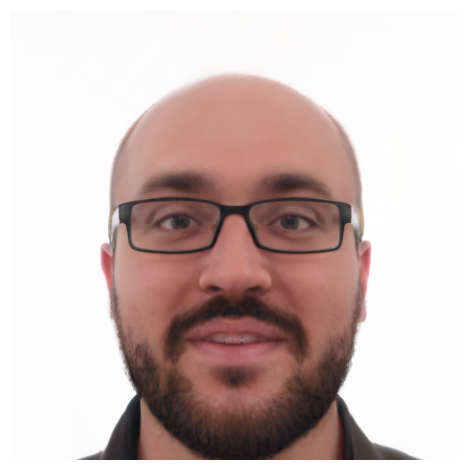

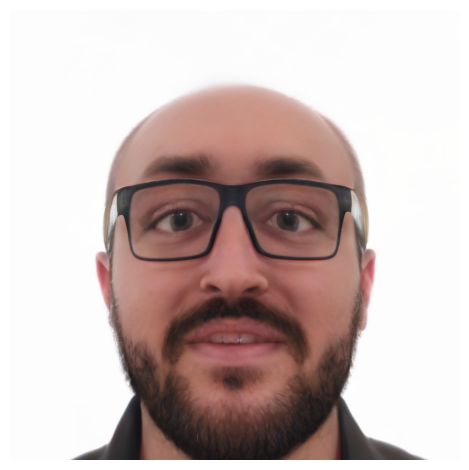

In [155]:
# add averaga_change to w1
img = lazy_Run(sg_pkl,w1,want_plot=True)
w_changed = w1 - 2*torch.tensor(averaga_change).to('cuda')
img = lazy_Run(sg_pkl,w_changed,want_plot=True)

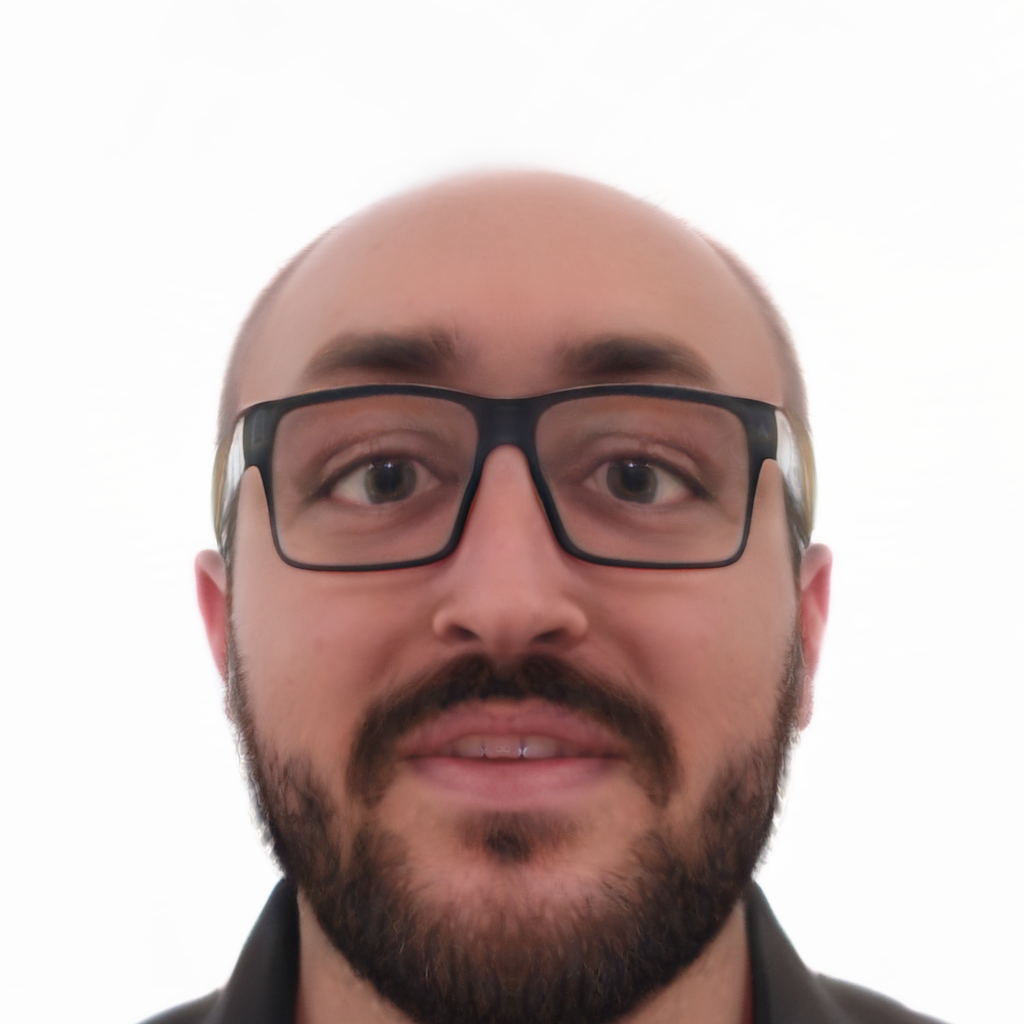

: 

In [156]:
# chang img to PIL image
import PIL
pil_img = PIL.Image.fromarray(img)
pil_img

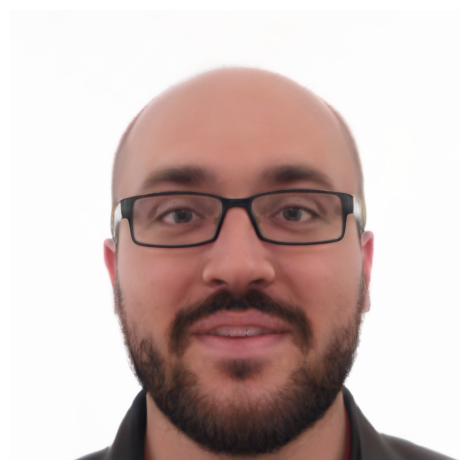

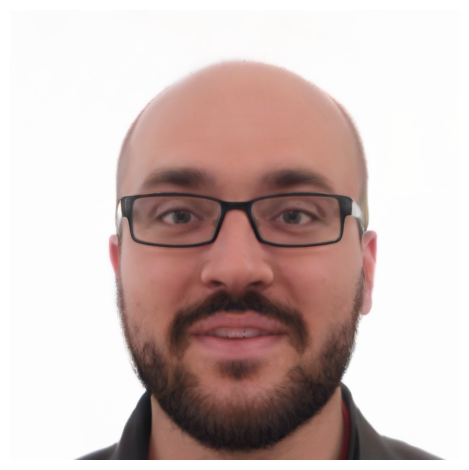

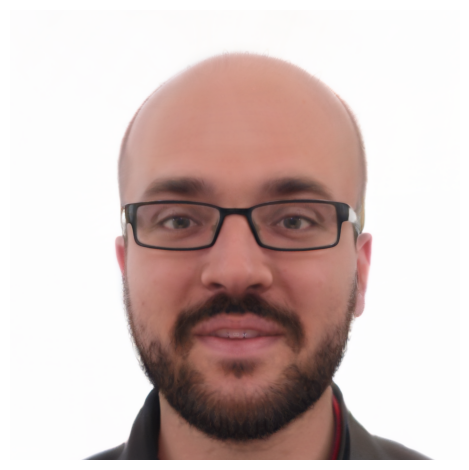

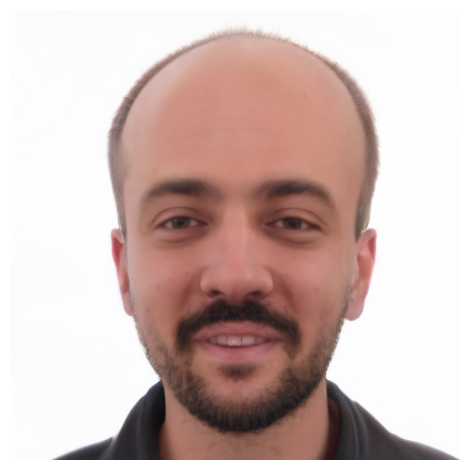

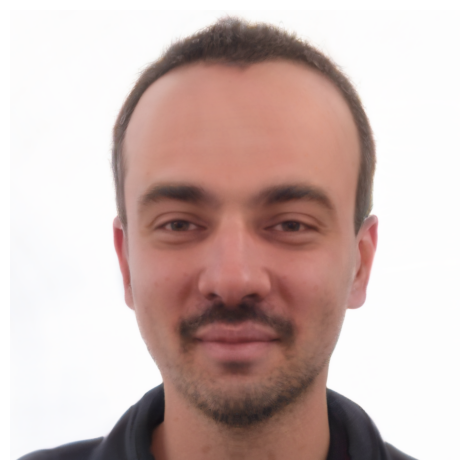

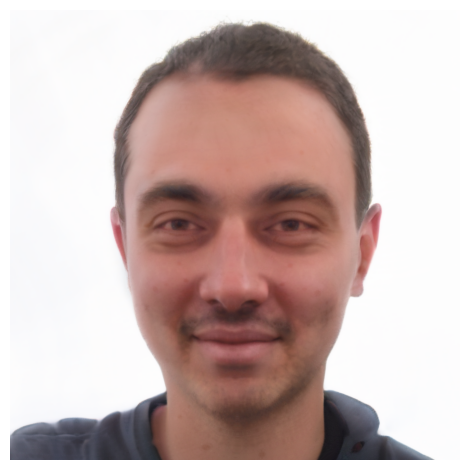

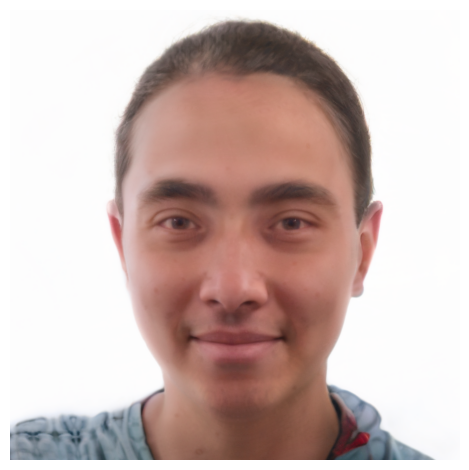

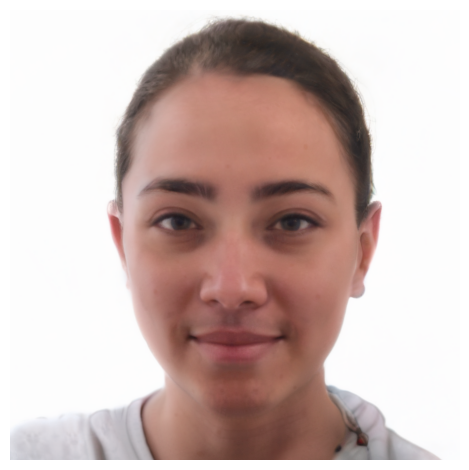

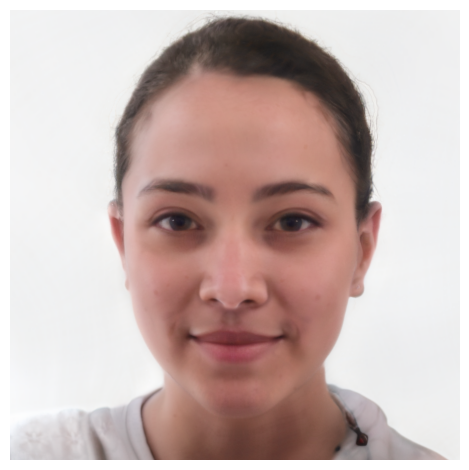

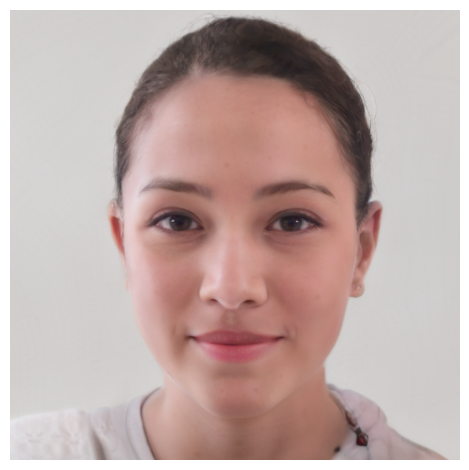

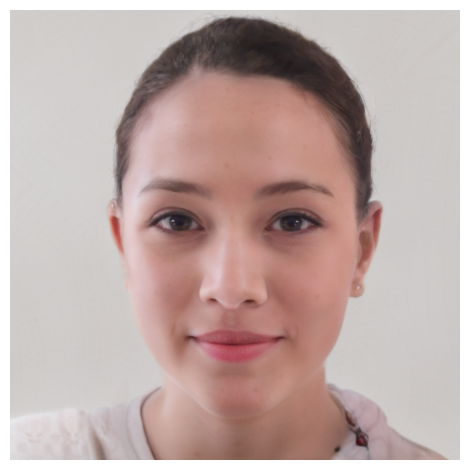

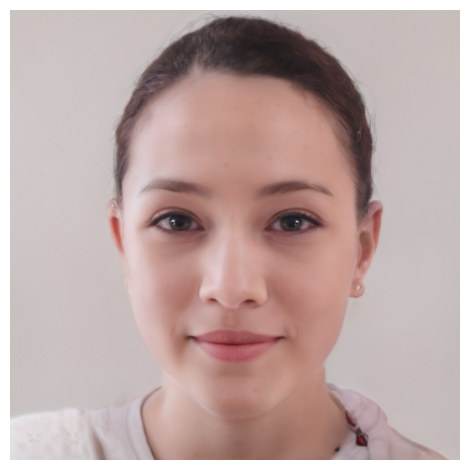

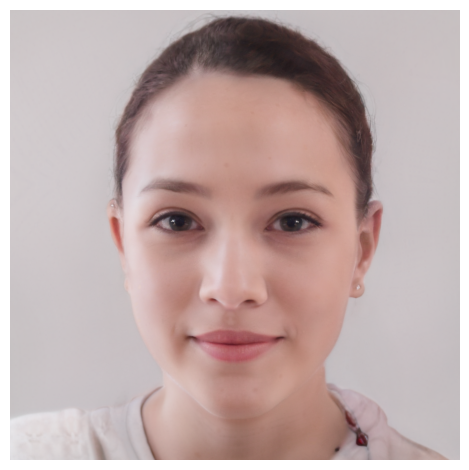

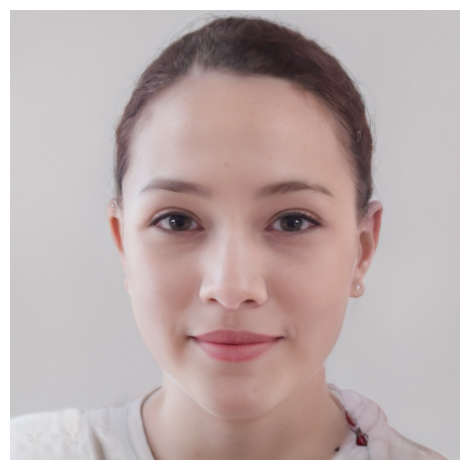

In [151]:
# add averaga_change to w1
sg_pkl = "/home/bean/DragVideo/Data_store/OLD/model_weights/stylegan3_3rdtime_weights/stylegan3-r-ffhq-1024_module.pkl"

w1_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg/latents/barcelona/PTI/010/0.pt"
w1 = torch.load(w1_path)

w2_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_mirrAR_200_frames/latents/barcelona/PTI/000/0.pt"
w2 = torch.load(w2_path)
w2.requires_grad = False

w_copy = w2.clone()
for n in range(1,15):
    # w[:,n:] = w1[:,n:]
    w_copy[:,n:] = w1[:,n:]
    w_copy[:,:n] = w2[:,:n]
    img = lazy_Run(sg_pkl,w_copy,want_plot=True)
# w_changed = w2 - 2*torch.tensor(averaga_change).to('cuda')
# img = lazy_Run(sg_pkl,w_changed,want_plot=True)

In [150]:
w2.shape

torch.Size([1, 16, 512])

In [1]:
import os
os.chdir("/home/bean/DragVideo/DragGAN")
from _do_drag import DragVideo
dragvideo = DragVideo(stylegan2_wieghts_path="/home/bean/DragVideo/Data_store/experiments/sep_1_smile_working_sg2/tuned_SG/stylegan2_DCTGOWDSLXTB.pkl",
                        inputs_dir = "/home/bean/DragVideo/Data_store/experiments/sep_1_smile_working_sg2",
                        outputs_dir = "/home/bean/DragVideo/Data_store/experiments/new",
                        # editing_function_name = "smile",
                        image_size = 1024,
                        # N_STEPS=50,
                        device = "cpu",
                        verbose=False,)

intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/sep_4_vsause_frown_sg3/tuned_SG/stylegan3_EZXZEVVUYSPX.pkl"... Done.
()
{'z_dim': 512, 'w_dim': 512, 'channel_base': 65536, 'channel_max': 1024, 'mapping_kwargs': {}, 'conv_kernel': 1, 'filter_size': 6, 'magnitude_ema_beta': 0.9988915792636801, 'output_scale': 0.25, 'c_dim': 0, 'img_resolution': 1024, 'img_channels': 3, 'use_radial_filters': True}
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


In [ ]:
# dragvideo.run(N_STEPS=50,edit_mode="smile")

In [2]:

    # def run(self,N_STEPS=50,
    #         edit_mode="smile"):
    #     torch.cuda.empty_cache()
    #     latents,landmarks = self.get_available_latents_and_landmarks()
    #     zip_list = zip(latents,landmarks)
    #     for w_load_path,landmark_path in zip_list:
    #         points = self.get_drag_points(edit_mode,landmark_path,MAX_SIZE=self.image_size)
    #         self.drag_one_frame(w_load_path,points,N_STEPS=N_STEPS)
    #         self.save_outputs()
    
latents,landmarks = dragvideo.get_available_latents_and_landmarks()
points = dragvideo.get_drag_points("smile",landmarks[0],MAX_SIZE=1024)
dragvideo.drag_one_frame(latents[0],points,N_STEPS=50)

Total 120 images to be processed...
editing mode is: smile


  0%|          | 0/50 [00:00<?, ?it/s]/home/bean/.conda/envs/stylegan3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 0/50 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB (GPU 0; 23.68 GiB total capacity; 22.10 GiB already allocated; 779.81 MiB free; 22.36 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF